In [1]:
import pandas as pd
import numpy as np
import os, sys
sys.path.append("../")
sys.path.append("../../")

# 경고 메세지 off
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import silhouette_score # 성능 지표를 계산하기 위해 silhouette_score import
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
SEED=23
from Clust.clust.ML.clustering import kMeans
from Clust.clust.ML.clustering.kMeans import KMeansTrain, KMeansTest

In [2]:
# Data load
address = './../data_processing/Dataset/'
data = pd.read_csv(os.path.join(address,'df_pm10_7day_result_1110.csv'), header = 0, encoding='cp949')

In [3]:
# in_serial = 장소 정보와 in_id =data sample id만 data_cd로 생성
data_cd = data[['in_serial','in_id']]

In [4]:
data_cd = data_cd.drop_duplicates().set_index(keys='in_id')
# 클러스터링을 진행하기 위해 data table 형태 변환
df_pivot = pd.DataFrame()
for in_data_cd in data['in_id'].unique():
    sample = data[data['in_id'] == in_data_cd]
    time_index = []
    for i in range(0,len(sample)):
        time_index.append(i)
    sample['time_index'] = time_index
    df_pivot = pd.concat([df_pivot,sample], ignore_index=True)
df_pivot= df_pivot.pivot_table(index="time_index", columns="in_id", values="in_pm10_day")

#  1. 1일 데이터로 자르기

In [5]:
data_origin = df_pivot.loc[:143]
data_origin

in_id       ICL1L2000011  ICL1L2000017  ICL1L2000064  ICL1L2000065  \
time_index                                                           
0                   21.5          11.4          15.3          16.2   
1                   22.3          11.3          15.2          16.2   
2                   21.8          11.3          16.1          16.6   
3                   21.5          11.5          14.5          16.7   
4                   21.5          11.1          16.9          16.9   
...                  ...           ...           ...           ...   
139                 40.0          13.4          41.7          16.7   
140                 39.2          13.4          41.1          16.9   
141                 45.4          13.1          40.5          17.0   
142                 44.3          13.3          41.3          16.3   
143                 43.1          14.8          42.2          15.8   

in_id       ICL1L2000234  ICL1L2000235  ICL1L2000236  ICL1L2000237  \
time_index                                                           
0                   43.3          29.1          18.6          23.5   
1                   43.5          28.8          18.5          23.3   
2                   42.5          27.8          18.6          23.7   
3                   41.9          27.0          19.0          23.6   
4                   42.2          27.5          18.5          23.8   
...                  ...           ...           ...           ...   
139                 23.5           3.0          58.9          19.1   
140                 23.7           2.8          57.8          19.6   
141                 23.0           2.7          57.5          19.4   
142                 22.0           2.4          56.3          19.4   
143                 22.0           2.4          57.5          19.1   

in_id       ICL1L2000238  ICL1L2000239  ...  ICW0W2100277  ICW0W2100278  \
time_index                              ...                               
0                   61.0          52.7  ...           3.0           3.2   
1                   60.9          52.5  ...           3.2           3.8   
2                   60.6          52.5  ...           3.4           3.3   
3                   60.4          52.6  ...           3.4           3.7   
4                   60.2          52.0  ...           3.6           3.8   
...                  ...           ...  ...           ...           ...   
139                 64.7          24.0  ...           8.7           7.5   
140                 65.3          22.3  ...           8.1           7.8   
141                 65.0          22.0  ...           8.6           7.1   
142                 67.2          21.9  ...           7.9           6.9   
143                 65.4          20.7  ...           7.5           6.9   

in_id       IS70W2000822  IS70W2000851  IS70W2000852  IS70W2000853  \
time_index                                                           
0                  98.97           9.9           5.0           5.9   
1                  98.94           8.5           5.0           6.2   
2                  98.76           8.2           4.4           6.0   
3                  98.42           8.2           4.5           5.6   
4                  98.59           6.9           5.4           5.6   
...                  ...           ...           ...           ...   
139                96.94           2.0           3.0           1.3   
140                96.91           1.8           3.0           1.6   
141                97.21           2.2           2.4           2.0   
142                97.28           2.3           2.9           2.2   
143                97.33           1.9           2.2           1.5   

in_id       IS70W2000854  IS70W2000855  IS70W2000856  IS70W2000858  
time_index                                                          
0                    0.7           8.7          14.1          12.6  
1                    1.0           9.5          14.6          12.2  
2              

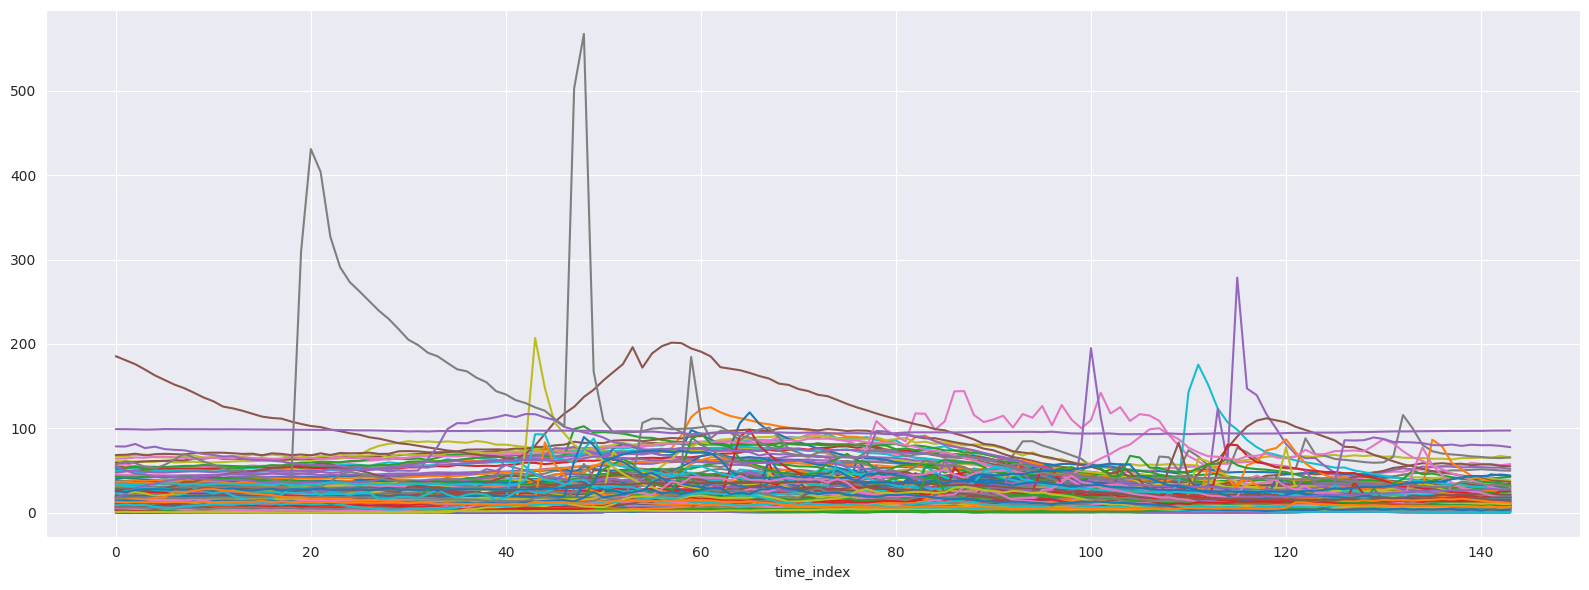

In [6]:
data_origin.plot(legend = False, figsize=(16,6))
plt.tight_layout()
plt.show()

#  2. 각 컬럼 데이터 NaN 데이터 처리

In [7]:
data = data_origin.interpolate(method='linear') 
print("NaN processing (count):", np.isnan(data_origin.values).sum(), "->", np.isnan(data.values).sum())

NaN processing (count): 45 -> 0


In [8]:
# Scaling
from Clust.clust.preprocessing import processing_interface
process_param={'flag': True, 'emw_param':0.3}
data = processing_interface.get_data_result('smoothing', data, process_param)
process_param={'flag': True, 'method':'minmax'} 
data = processing_interface.get_data_result('scaling', data, process_param)

In [9]:
data_scaled

ICL1L2000011  ICL1L2000017  ICL1L2000064  ICL1L2000065  \
time_index                                                           
0               0.474134      0.023333      0.017645      0.172609   
1               0.489168      0.019723      0.014651      0.172609   
2               0.482864      0.019074      0.039941      0.187372   
3               0.476130      0.025788      0.000000      0.194262   
4               0.474594      0.013638      0.058965      0.203130   
...                  ...           ...           ...           ...   
139             0.907361      0.106696      0.986621      0.193330   
140             0.889018      0.110931      0.972578      0.202909   
141             0.995092      0.101654      0.952330      0.208765   
142             1.000000      0.106350      0.970334      0.184598   
143             0.979783      0.158703      1.000000      0.160794   

            ICL1L2000234  ICL1L2000235  ICL1L2000236  ICL1L2000237  \
time_index                                                           
0               0.549718      0.675023      0.009279      0.299534   
1               0.553306      0.668857      0.007245      0.288291   
2               0.536754      0.648046      0.008829      0.307823   
3               0.522908      0.627873      0.016900      0.306766   
4               0.524849      0.633009      0.009107      0.317176   
...                  ...           ...           ...           ...   
139             0.114330      0.015386      1.000000      0.006314   
140             0.116335      0.010987      0.992683      0.024303   
141             0.104909      0.008026      0.985218      0.017811   
142             0.085287      0.001505      0.960390      0.016312   
143             0.080758      0.000000      0.977766      0.000000   

            ICL1L2000238  ICL1L2000239  ...  ICW0W2100277  ICW0W2100278  \
time_index                              ...                               
0               0.209419      0.445414  ...      0.000000      0.000000   
1               0.206682      0.443132  ...      0.004161      0.023447   
2               0.198317      0.442722  ...      0.008897      0.008932   
3               0.191286      0.443715  ...      0.009935      0.020593   
4               0.184495      0.437454  ...      0.014113      0.026955   
...                  ...           ...  ...           ...           ...   
139             0.331572      0.045080  ...      0.148259      0.204381   
140             0.349062      0.024544  ...      0.134667      0.217351   
141             0.345323      0.016563  ...      0.141379      0.194447   
142             0.401482      0.013641  ...      0.129140      0.181761   
143             0.367787      0.000000  ...      0.118437      0.178834   

            IS70W2000822  IS70W2000851  IS70W2000852  IS70W2000853  \
time_index                                                           
0               1.000000      0.277085      0.075883      0.172222   
1               0.995929      0.239388      0.075883      0.181483   
2               0.971783      0.224870      0.064452      0.177230   
3               0.922684      0.221689      0.063835      0.164573   
4               0.933342      0.187802      0.080641      0.161686   
...                  ...           ...           ...           ...   
139             0.656366      0.017659      0.022903      0.000000   
140             0.656028      0.010729      0.026022      0.006795   
141             0.694495      0.019326      0.015452      0.020055   
142             0.712365      0.023860      0.022421      0.028960   
143             0.722913      0.014709      0.010857      0.010556   

            IS70W2000854  IS70W2000855  IS70W2000856  IS70W2000858  
time_index                                                          
0               0.023379      0.368335      0.431712      0.773580  
1               0.031519      0.396896      0.446309      0.742502  
2               0.025179   

#  3. Clustering
## 3-1. Clustering 파라미터를 정하기 위한 단계

In [10]:
kmeans_metrics_list =['euclidean', 'dtw', 'softdtw']
kmeans_metrics = kmeans_metrics_list[1]

  0%|          | 0/7 [00:00<?, ?it/s]

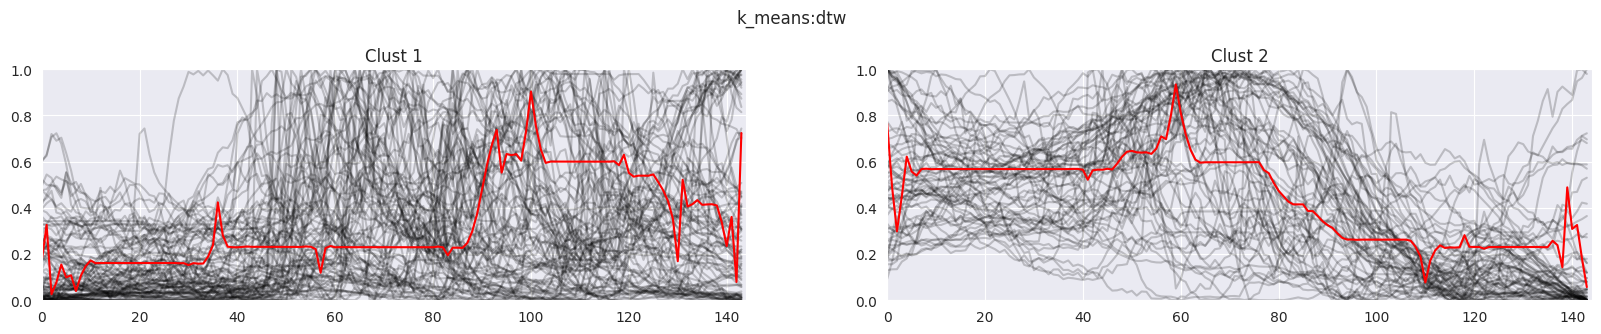

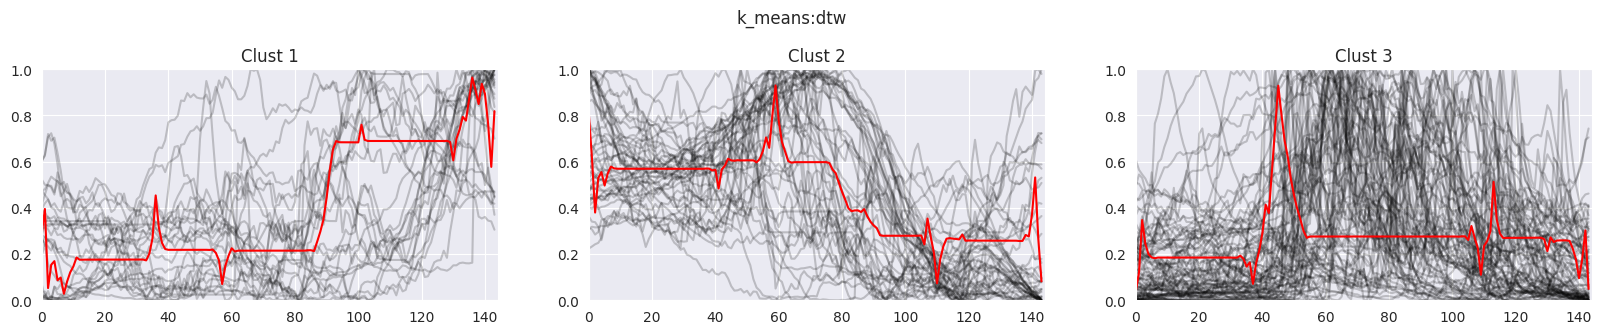

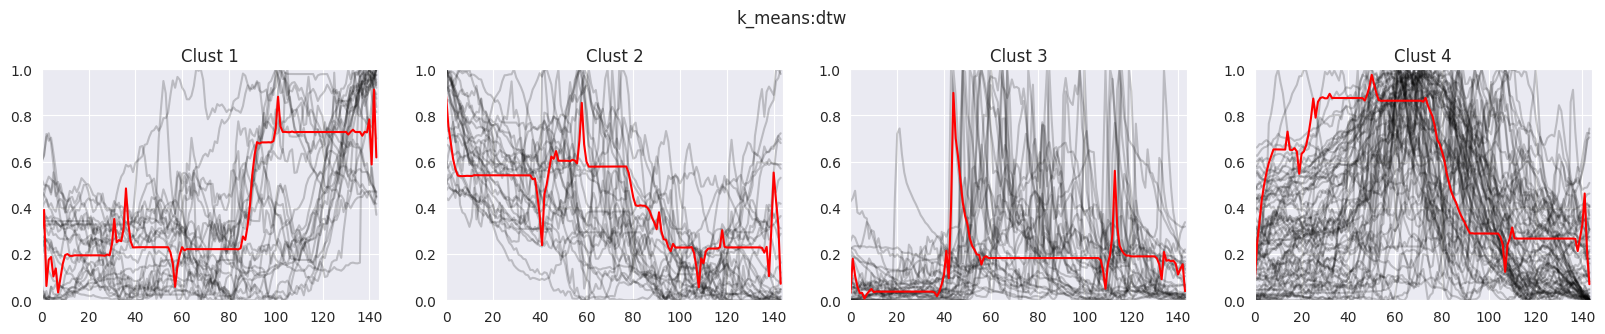

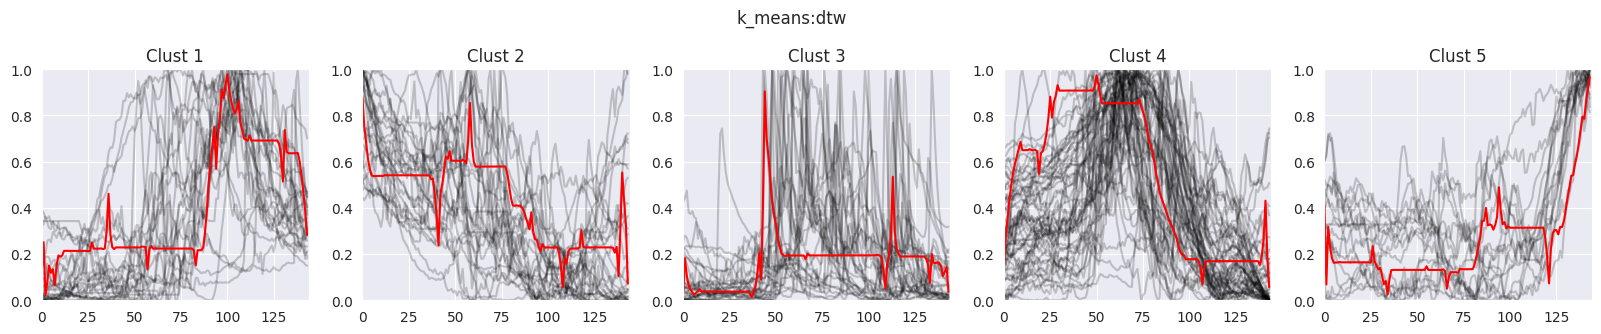

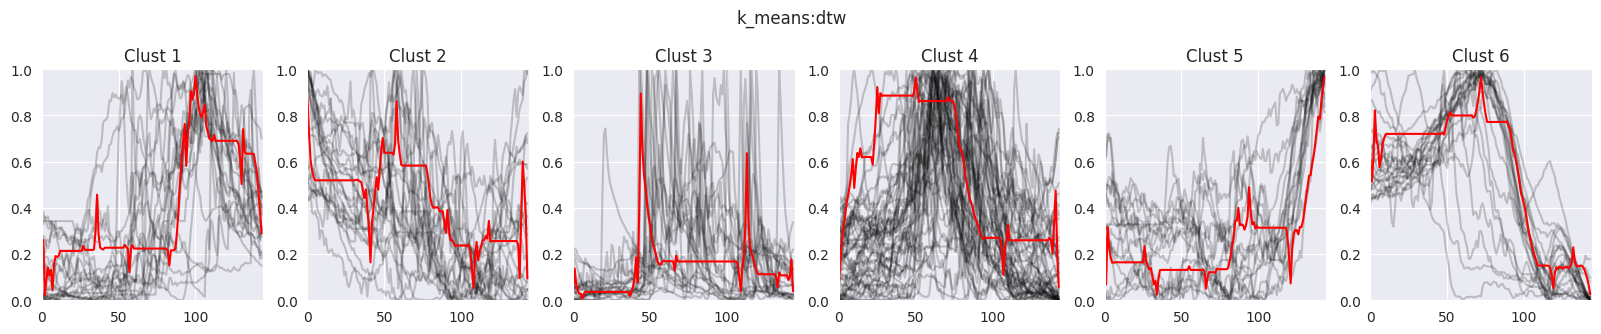

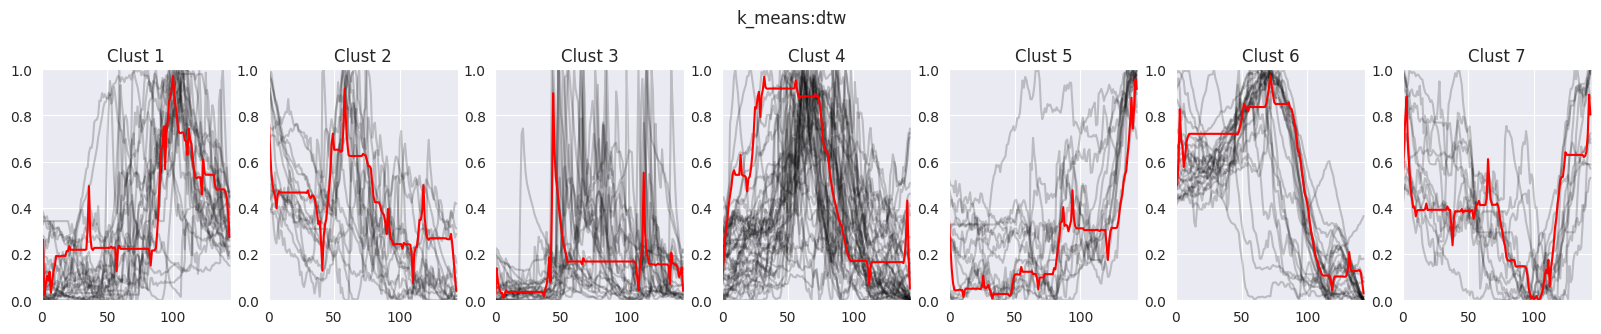

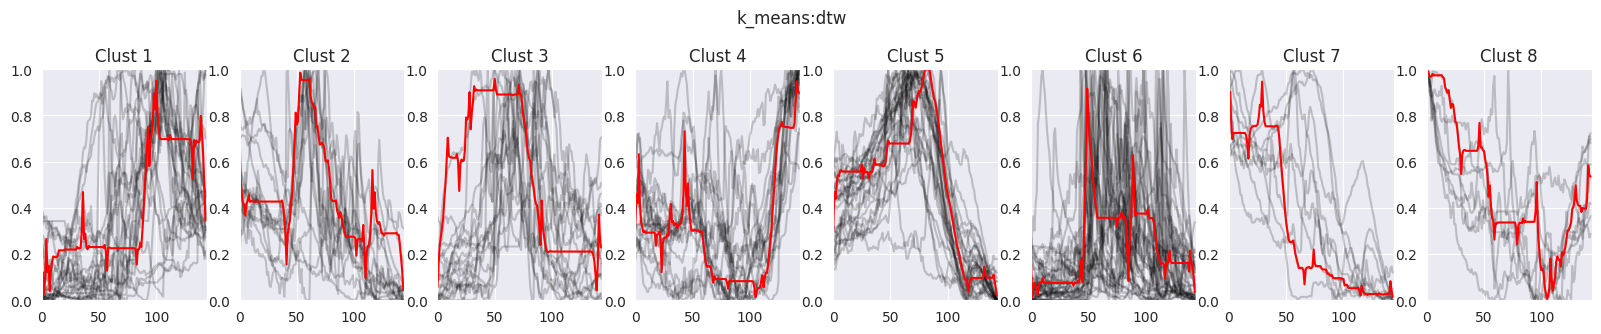

In [11]:
# 1. 데이터 준비
from Clust.clust.ML.tool.data import DF_to_series
data_series = DF_to_series(data_scaled)
data_name = list(data_scaled.columns)

# 2.Search Param
max_cluster = 9
param = {"n_clusters":max_cluster,  "metric":kmeans_metrics}
metrics = kMeans.search_best_n_clust(data_series, param)

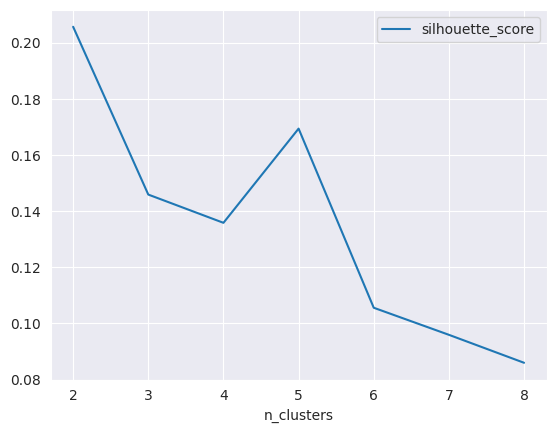

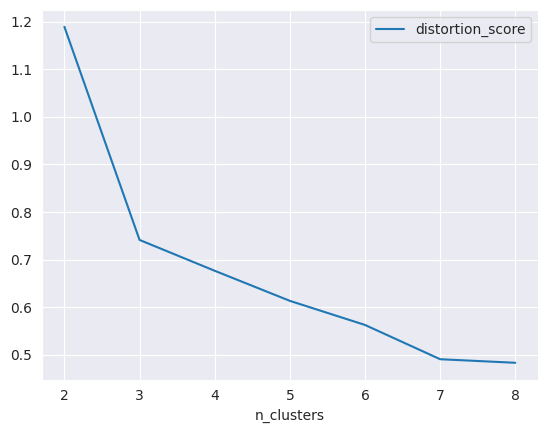

In [12]:
metrics[["silhouette_score"]].plot()
plt.show()
metrics[["distortion_score"]].plot()
plt.show()

## 3-3. Clustering Model 활용

### 1. Clustering 모델 테스트

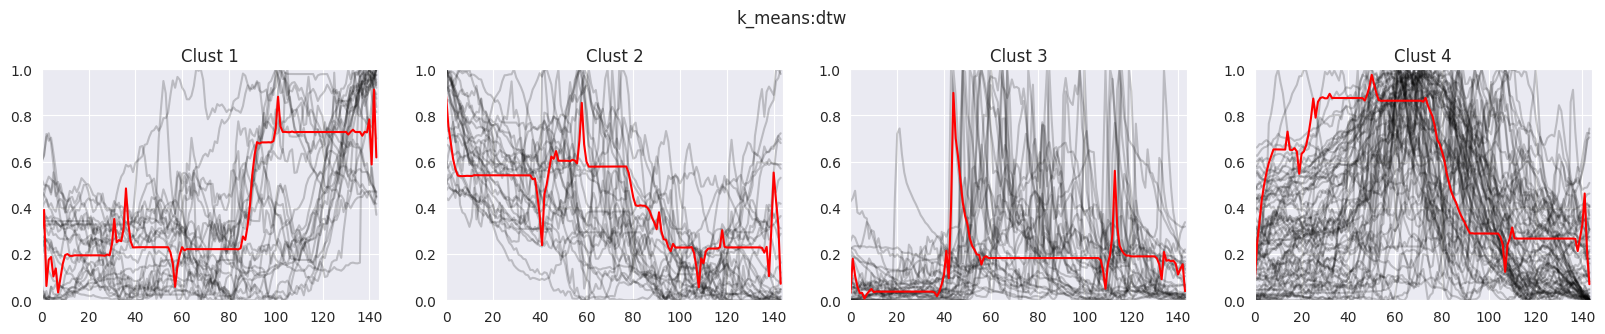

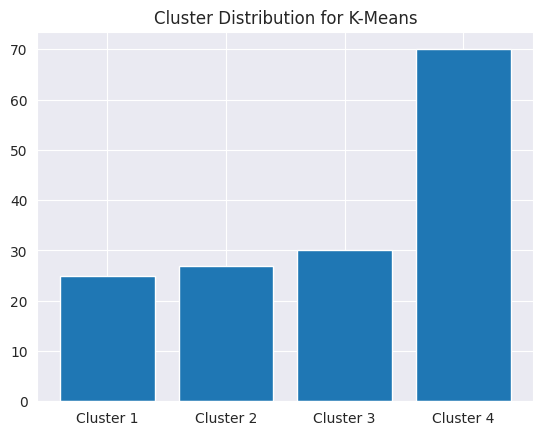

In [13]:
from Clust.clust.ML.tool.model import load_pickle_model, save_pickle_model
from Clust.clust.ML.tool import util

# 1. set param

max_cluster = 4
param = {"n_clusters":max_cluster,  "metric":kmeans_metrics}
parameter = {"method":"kmeans", "param":param}

from Clust.clust.ML.clustering.interface import clusteringByMethod
model_path = "model.pkl"
result, figdata1= clusteringByMethod(data_scaled, parameter, model_path)

## 3-4. Clustering 결과 확인 (Train, Test)

Dimension:  144 ----> 2


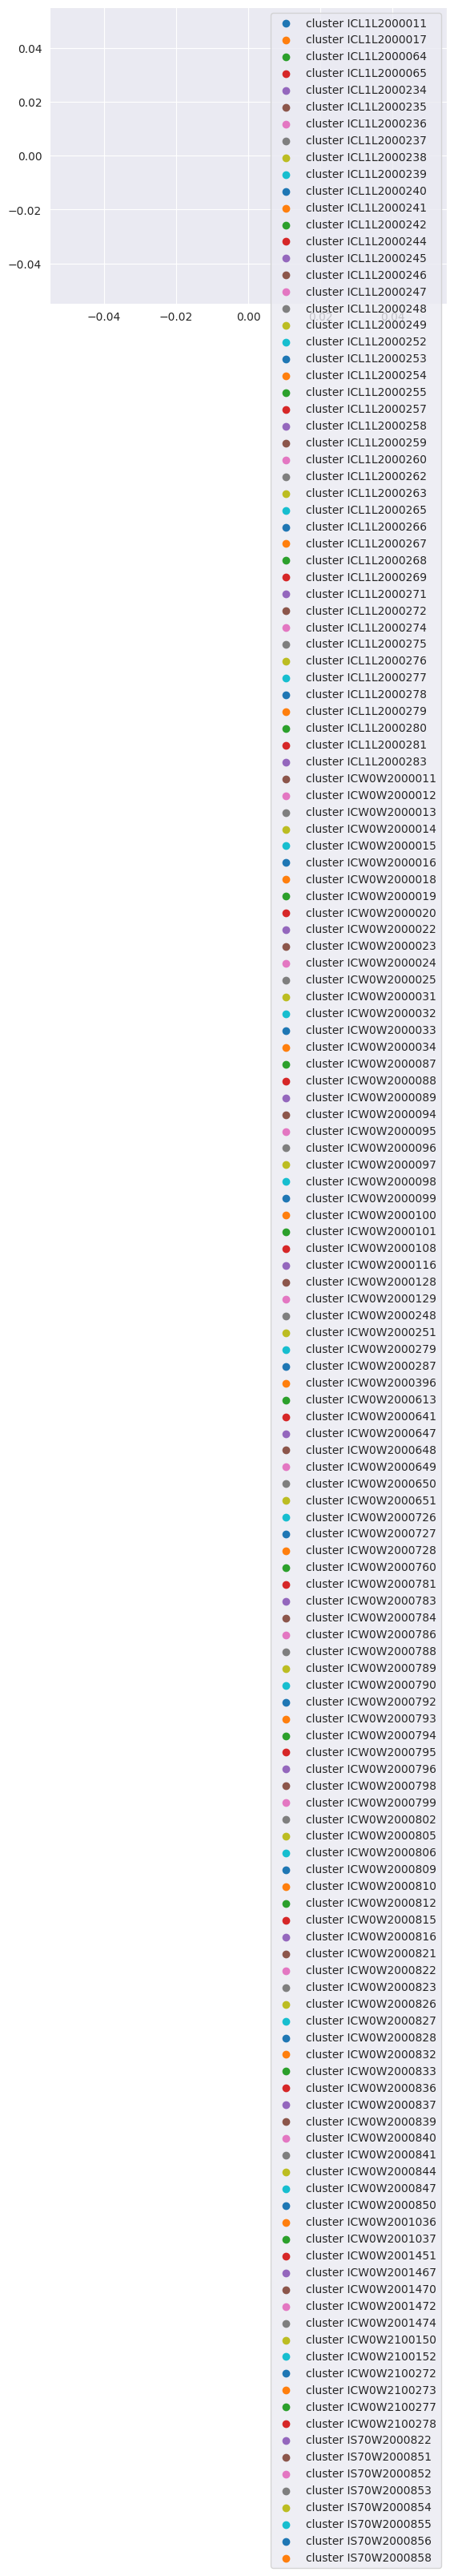

In [14]:
from Clust.clust.transformation.featureReduction.pca import show_clustering_result_by2DPCA
data_2d = show_clustering_result_by2DPCA(data_series, result)

In [15]:
from Clust.clust.ML.tool.util import count_label_info
count = count_label_info(result)
print(count)

[('ICL1L2000011', 1), ('ICL1L2000017', 3), ('ICL1L2000064', 0), ('ICL1L2000065', 3), ('ICL1L2000234', 3), ('ICL1L2000235', 1), ('ICL1L2000236', 0), ('ICL1L2000237', 3), ('ICL1L2000238', 3), ('ICL1L2000239', 3), ('ICL1L2000240', 3), ('ICL1L2000241', 3), ('ICL1L2000242', 3), ('ICL1L2000244', 3), ('ICL1L2000245', 3), ('ICL1L2000246', 3), ('ICL1L2000247', 3), ('ICL1L2000248', 3), ('ICL1L2000249', 3), ('ICL1L2000252', 3), ('ICL1L2000253', 3), ('ICL1L2000254', 3), ('ICL1L2000255', 3), ('ICL1L2000257', 3), ('ICL1L2000258', 3), ('ICL1L2000259', 3), ('ICL1L2000260', 3), ('ICL1L2000262', 3), ('ICL1L2000263', 2), ('ICL1L2000265', 0), ('ICL1L2000266', 0), ('ICL1L2000267', 1), ('ICL1L2000268', 3), ('ICL1L2000269', 3), ('ICL1L2000271', 1), ('ICL1L2000272', 3), ('ICL1L2000274', 3), ('ICL1L2000275', 3), ('ICL1L2000276', 3), ('ICL1L2000277', 0), ('ICL1L2000278', 3), ('ICL1L2000279', 3), ('ICL1L2000280', 3), ('ICL1L2000281', 2), ('ICL1L2000283', 3), ('ICW0W2000011', 1), ('ICW0W2000012', 2), ('ICW0W20000